<a href="https://colab.research.google.com/github/ComeBackCity/ML_Project/blob/main/ML_Project_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)
 
import keras
keras.__version__

2.8.0


'2.8.0'

In [2]:
# main part
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
from keras.layers.core import  Dropout
from keras.regularizers import l2
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model
from keras import backend as K 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import gc
from random import sample
import math
import random

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# imagePath = r'/content/drive/MyDrive/Xing_Project/MultiResNet/Data/archive/Segmentation/Original'
# maskPath = r'/content/drive/MyDrive/Xing_Project/MultiResNet/Data/archive/Segmentation/Mask'
# extraPath =  r'/content/drive/MyDrive/Xing_Project/MultiResNet/Data/archive/Segmentation/Extra'
imagePath = r'/content/drive/MyDrive/archive/Segmentation/Original'
maskPath = r'/content/drive/MyDrive/archive/Segmentation/Mask'
extraPath =  r'/content/drive/MyDrive/archive/Segmentation/Extra'
imageCnt = 0
maskCnt = 0
imageFiles = os.listdir(imagePath)
maskFiles = os.listdir(maskPath)
imageFiles.sort()
maskFiles.sort()
print(len(imageFiles))
print(len(maskFiles))

assert len(imageFiles) == len(maskFiles)
for i in range(len(imageFiles)):
    imageCnt += 1
    assert imageFiles[i] == maskFiles[i]
    maskCnt += 1
print('images:  '+str(imageCnt)+'  masks:  '+str(maskCnt))

9000
9000
images:  9000  masks:  9000


In [5]:
# len_data = len(imageFiles) 
data = imageFiles
mask = imageFiles
len_data = len(data)

all_indices = [i for i in range(len_data)]
train_size = int(0.8 * len_data)

train_indices = sample(range(len_data),train_size)
test_indices = list(set(all_indices) - set(train_indices))

# print(train_indices)
# print(test_indices)


train_images = [data[i] for i in train_indices]
test_images = [data[i] for i in test_indices]

train_mask = [mask[i] for i in train_indices]
test_mask = [mask[i] for i in test_indices]

print(len(train_images))
print(len(test_images))
print()
print(len(train_mask))
print(len(test_mask))


7200
1800

7200
1800


In [6]:
class Custom_Dataset(tf.keras.utils.Sequence):
    
    def __init__(self,
                 image_path,
                 images,
                 mask_path,
                 masks,
                 batch_size, 
                 shuffle=True, 
                 ):
        self.images = images
        self.image_path = image_path
        self.mask_path = mask_path
        self.masks = masks
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(math.ceil(len(self.images)/self.batch_size))
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = [i for i in range(len(self.images))]
        if self.shuffle == True:
            random.shuffle(self.indexes)

    def __getitem__(self, index):
        # Generate indexes of the batch
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        X = []
        Y = []

        # print(batch_indexes)
        for item_index in batch_indexes:
            imageFile = self.images[item_index]
            maskFile = self.masks[item_index]

            # print(imageFile)
            # print(maskFile)
            assert imageFile == maskFile

            if (imageFile.split('.')[-1]=='png'):  

                img = cv2.imread('{}/{}'.format(imagePath, imageFile), cv2.IMREAD_COLOR)
                resized_img = cv2.resize(img,(256, 192), interpolation = cv2.INTER_CUBIC)
                X.append(resized_img)

                msk = cv2.imread('{}/{}'.format(maskPath,maskFile), cv2.IMREAD_GRAYSCALE)
                resized_msk = cv2.resize(msk,(256, 192), interpolation = cv2.INTER_CUBIC)
                Y.append(resized_msk)

        X = np.array(X)
        Y = np.array(Y)
  
        X = X / 255
        
        Y = Y.reshape((Y.shape[0],Y.shape[1],Y.shape[2],1))
        Y = np.round(Y/255,0)
        
        return X,Y

In [7]:
print(train_images[6731])
print(train_mask[6731])


2659.png
2659.png


In [8]:
# #Creating training set
# print(len(imageFiles))
# print(len(maskFiles))

# X = []
# Y = []
# index = 0
# for imageFile in tqdm(imageFiles):    
#   if (imageFile.split('.')[-1]=='png'):  
#     img = cv2.imread('{}/{}'.format(imagePath, imageFile), cv2.IMREAD_COLOR)
#     resized_img = cv2.resize(img,(256, 192), interpolation = cv2.INTER_CUBIC)
#     # X.append(img)
    
#     X.append(resized_img)
    
#     msk = cv2.imread('{}/{}'.format(maskPath, maskFiles[index]), cv2.IMREAD_GRAYSCALE)
#     resized_msk = cv2.resize(msk,(256, 192), interpolation = cv2.INTER_CUBIC)
#     # Y.append(msk)
    
#     Y.append(resized_msk)
#   index += 1
# print(str(len(X)), '  ', str(len(Y)))

In [9]:
train_generator = Custom_Dataset(
                    image_path = imagePath,
                    images = train_images,
                    mask_path = maskPath,
                    masks = train_mask,
                    batch_size = 32, 
                    shuffle=True, 
                 )

In [10]:
test_X = []
test_Y = []

for image in test_images:

    if (image.split('.')[-1]=='png'):  

        img = cv2.imread('{}/{}'.format(imagePath, image), cv2.IMREAD_COLOR)
        resized_img = cv2.resize(img,(256, 192), interpolation = cv2.INTER_CUBIC)
        test_X.append(resized_img)

        msk = cv2.imread('{}/{}'.format(maskPath,image), cv2.IMREAD_GRAYSCALE)
        resized_msk = cv2.resize(msk,(256, 192), interpolation = cv2.INTER_CUBIC)
        test_Y.append(resized_msk)

test_X = np.array(test_X)
test_Y = np.array(test_Y)

test_X = test_X / 255

test_Y = test_Y.reshape((test_Y.shape[0],test_Y.shape[1],test_Y.shape[2],1))
test_Y = np.round(test_Y/255,0)
print(test_X.shape)
print(test_Y.shape)

(1800, 192, 256, 3)
(1800, 192, 256, 1)


In [11]:
# # preparing testset

# print(len(X))
# print(len(Y))

# X = np.array(X)
# Y = np.array(Y)

# print(X.shape)
# print(Y.shape)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)
# Y_train = Y_train.reshape((Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],1))
# Y_test = Y_test.reshape((Y_test.shape[0],Y_test.shape[1],Y_test.shape[2],1))

# del X
# del Y
# gc.collect()

# X_train = X_train / 255
# X_test = X_test / 255
# Y_train = Y_train / 255
# Y_test = Y_test / 255

# Y_train = np.round(Y_train,0)	
# Y_test = np.round(Y_test,0)	

# print(X_train.shape)
# print(Y_train.shape)
# print(X_test.shape)
# print(Y_test.shape)

In [12]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x



In [13]:

def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x



In [14]:
def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


In [15]:


def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


In [16]:


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''

    current_block = MultiResBlock

    inputs = Input((height, width, n_channels))

    mresblock1 = current_block(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    # mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = current_block(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    # mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = current_block(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    # mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = current_block(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    # mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = current_block(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = current_block(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = current_block(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = current_block(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = current_block(32, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')
    
    model = Model(inputs=[inputs], outputs=[conv10])

    return model


In [17]:
def saveModel(model):

    model_json = model.to_json()

    '''try:
        os.makedirs('models')
    except:
        pass'''
    fileName = extraPath+'/modelP.json' 
    fp = open(fileName,'w')
    fp.write(model_json)
    fp.close()
    model.save_weights(extraPath+'/modelW.h5')

In [18]:
def loadModel():
  fileName = extraPath+'modelP.json'
  fp = open(fileName,'r')
  model_json = fp.read()
  fp.close()
  model = model_from_json(model_json)
  # load weights into new model
  model.load_weights(extraPath+'modelW.h5')
  print("Loaded model from disk")
  return model

In [19]:
def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)
    return intersection/union


In [27]:
def evaluateModel(model,X_test,Y_test,batchSize, epoch, ji, dc, epochs):
    
    # try:
    #     os.makedirs('./drive/MyDrive/Xing_Project/MultiResNet/results')
    # except:
    #     pass 
    

    yp = model.predict(x=X_test, batch_size=batchSize, verbose=1)

    yp = np.round(yp,0)

    for i in range(20):

        plt.figure(figsize=(20,10))
        plt.subplot(1,3,1)
        plt.imshow(X_test[i])
        plt.title('Input')
        plt.subplot(1,3,2)
        plt.imshow(Y_test[i].reshape(Y_test[i].shape[0],Y_test[i].shape[1]))
        plt.title('Ground Truth')
        plt.subplot(1,3,3)
        plt.imshow(yp[i].reshape(yp[i].shape[0],yp[i].shape[1]))
        plt.title('Prediction')

        intersection = yp[i].ravel() * Y_test[i].ravel()
        union = yp[i].ravel() + Y_test[i].ravel() - intersection

        jacard = (np.sum(intersection)/np.sum(union))  
        plt.suptitle('Jacard Index'+ str(np.sum(intersection)) +'/'+ str(np.sum(union)) +'='+str(jacard))

        plt.savefig(extraPath+'/images/'+str(epoch)+'_'+str(i)+'.png',format='png')
        plt.close()


    jacard = 0
    dice = 0
    
    
    for i in range(len(Y_test)):
        yp_2 = yp[i].ravel()
        y2 = Y_test[i].ravel()
        
        intersection = yp_2 * y2
        union = yp_2 + y2 - intersection

        jacard += (np.sum(intersection)/np.sum(union))  

        dice += (2. * np.sum(intersection) ) / (np.sum(yp_2) + np.sum(y2))

    
    jacard /= len(Y_test)
    dice /= len(Y_test)
    
    if not epochs:
        epochs.append(0)
    else:
        epochs.append(epochs[-1]+1)

    ji.append(jacard)
    dc.append(dice)

    print('Jacard Index : '+str(jacard))
    print('Dice Coefficient : '+str(dice))
    
    with open(extraPath+'/log.txt','a') as fp:
        fp.write(str(jacard)+'\n')
    
    with open(extraPath+'/best.txt','r') as fp:
        best = fp.read()

    if(jacard>float(best)):
        print('***********************************************')
        print('Jacard Index improved from '+str(best)+' to '+str(jacard))
        print('***********************************************')
        with open(extraPath+'/best.txt','w') as fp:
            fp.write(str(jacard))
        
        saveModel(model)

In [28]:
def trainStep(model, train_generator, X_test, Y_test, epochs):

    jacard_indices = []
    dice_coeffs = []
    iters = []
    for epoch in range(epochs):
        print('Epoch : {}'.format(epoch+1))
        model.fit(x=train_generator, epochs=1, verbose=1)     

        evaluateModel(model,X_test, Y_test,32, epoch, jacard_indices, dice_coeffs, iters)

    return model, jacard_indices, dice_coeffs, iters


In [33]:
model = MultiResUnet(height=192, width=256, n_channels=3)
#model = loadModel()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #dice_coef, jacard, 
#model.summary()
# saveModel(model)

fp = open(extraPath + '/log.txt','w')
fp.close()
fp = open(extraPath + '/best.txt','w')
fp.write('-1.0')
fp.close()
    
_, a, b, c = trainStep(model, train_generator, test_X, test_Y, epochs=20)

Epoch : 1
57/57 [==============================] - 13s 221ms/step
Jacard Index : 0.3295447355419565
Dice Coefficient : 0.40061850919151293
***********************************************
Jacard Index improved from -1.0 to 0.3295447355419565
***********************************************
Epoch : 2
57/57 [==============================] - 12s 222ms/step
Jacard Index : 0.8608394013405832
Dice Coefficient : 0.921504183456569
***********************************************
Jacard Index improved from 0.3295447355419565 to 0.8608394013405832
***********************************************
Epoch : 3
57/57 [==============================] - 12s 221ms/step
Jacard Index : 0.9035077088702896
Dice Coefficient : 0.9468428882472556
***********************************************
Jacard Index improved from 0.8608394013405832 to 0.9035077088702896
***********************************************
Epoch : 4
57/57 [==============================] - 12s 221ms/step
Jacard Index : 0.9302854534824231
Dice Coe

In [34]:
a

[0.3295447355419565,
 0.8608394013405832,
 0.9035077088702896,
 0.9302854534824231,
 0.9412381328338205,
 0.9270832358148777,
 0.9362890684430171,
 0.9380732556211107,
 0.9362732845225485,
 0.9368650365828336,
 0.928988239289187,
 0.9323664514834964,
 0.9379871482690234,
 0.9376368710880996,
 0.9386894539703297,
 0.939385987065019,
 0.9316950501995761,
 0.9051979599012423,
 0.9394225033049627,
 0.9255361515051075]

In [35]:
b

[0.40061850919151293,
 0.921504183456569,
 0.9468428882472556,
 0.962110580805118,
 0.9681156491348077,
 0.9603059379862456,
 0.9652821090588066,
 0.9664385180177798,
 0.9655063412659778,
 0.9657221765318675,
 0.9615163935500427,
 0.9633730998165378,
 0.9665885292707718,
 0.9664148131214653,
 0.9673880460859382,
 0.9675883211371165,
 0.9633701184287732,
 0.9486310806688315,
 0.9677328673963764,
 0.960144733786788]

In [36]:
c

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

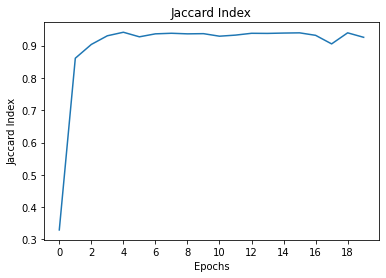

In [40]:
plt.plot(c, a)
plt.title('Jaccard Index')
plt.xlabel('Epochs')
plt.ylabel('Jaccard Index')
plt.xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18])
plt.show()

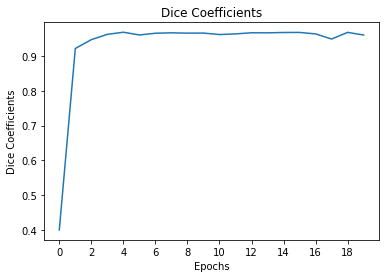

In [42]:
plt.plot(c, b)
plt.title('Dice Coefficients')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficients')
plt.xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18])
plt.show()

In [26]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)